In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#changing the working directory
import os
os.chdir('gdrive/My Drive/Colab_Notebooks/Kaggle/E_Commerce_Company_Customer_Behaviors_Analysis')

In [ ]:
#Importing necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.float_format = "{:,.2f}".format
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import warnings
warnings.simplefilter("ignore")

In [ ]:
#user defined functions
def extract_categorycode(input_text,level=0):
    '''
     this function splits category code and returns the first part.
    '''
    try:
      output_text=input_text.split('.')[level]
    except:
      output_text=''
    return output_text

def create_clusters(input_data_frame,input_columns,n_cluster):
  '''
  This function creates clusters and cluster labels.
  '''
  from sklearn.cluster import KMeans
  X=input_data_frame[input_columns].values
  k_means=KMeans(n_clusters=n_cluster,random_state=15).fit(X)
  return k_means.labels_

In [ ]:
#reading data
file_loc="2019-Oct.csv"
dataset=pd.read_csv(file_loc)

In [ ]:
#converting datatypes for decreasing RAM usage
dataset['event_time']=pd.to_datetime(dataset['event_time']).dt.tz_convert(None)
dataset['event_type']=dataset['event_type'].astype('category')
dataset['category_id']=dataset['category_id'].astype('category')
dataset['category_code']=dataset['category_code'].astype('category')
dataset['brand']=dataset['brand'].astype('category')

Category Analysis

In [ ]:
#splitting the category text into 2 pieces as category and subcategory
dataset['category']=dataset['category_code'].apply(extract_categorycode,level=0)
dataset['subcategory']=dataset['category_code'].apply(extract_categorycode,level=1)

In [ ]:
#calculating and printing informative numerical information about the dataset.
total_number_of_activity=dataset.shape[0]
print('Total number of activity:{:,.0f}'.format(total_number_of_activity))
print('-'*50)
total_number_of_visits=dataset['user_session'].nunique()
print('Total number of visits:{:,.0f}'.format(total_number_of_visits))
print('-'*50)
total_number_of_visitors=dataset['user_id'].nunique()
print('Total number of visitors:{:,.0f}'.format(total_number_of_visitors))
print('-'*50)
number_of_categories=dataset['category'].nunique()
print('The number of categories:{:,.0f}'.format(number_of_categories))
print('-'*50)
number_of_subcategories=dataset['subcategory'].nunique()
print('The number of subcategories:{:,.0f}'.format(number_of_subcategories))
print('-'*50)
number_of_brands=dataset['brand'].nunique()
print('The number of brands:{:,.0f}'.format(number_of_brands))
print('-'*50)
number_of_products=dataset['product_id'].nunique()
print('The number of products:{:,.0f}'.format(number_of_products))


Total number of activity:42,448,764
--------------------------------------------------
Total number of visits:9,244,421
--------------------------------------------------
Total number of visitors:3,022,290
--------------------------------------------------
The number of categories:13
--------------------------------------------------
The number of subcategories:57
--------------------------------------------------
The number of brands:3,444
--------------------------------------------------
The number of products:166,794


In [ ]:
#creating a summary table that contains an outline of categories and activities
category_summary_table=dataset.groupby(by=['category']).agg(Number_of_views=('category','count'),
                                                              Number_of_users=('user_id',lambda x: x.nunique()),
                                                              Number_of_sessions=('user_session',pd.Series.nunique)).reset_index()
sales_filter=dataset['event_type']=='purchase'
category_sales_summary_table=dataset.loc[sales_filter].groupby(by=['category']).agg(Number_of_purchase=('category','count'),
                                                                                      Amount_of_purchase=('price','sum'),
                                                                                      Average_purchase_amount=('price','mean'),
                                                                                      Number_of_sessions_with_purchase=('user_session',pd.Series.nunique),
                                                                                      Number_of_shoppers=('user_id',lambda x: x.nunique())).reset_index()
category_summary_table=pd.merge(left=category_summary_table,
                               right=category_sales_summary_table,
                               left_on='category',
                               right_on='category',
                               how='left')
category_summary_table['Conversion_rate']=category_summary_table['Number_of_purchase']/category_summary_table['Number_of_sessions']

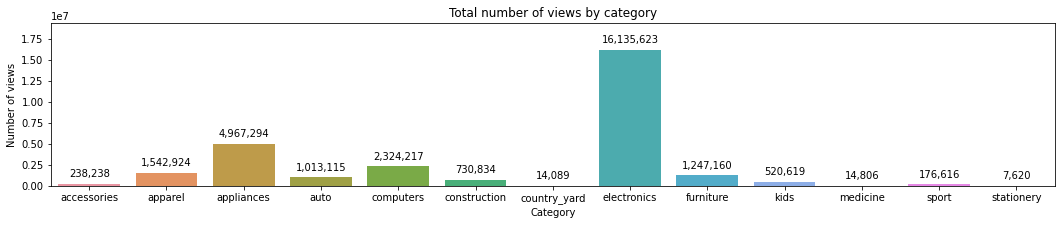

In [ ]:
#creating a plot that illustrates number of visits in each category during October
plt.figure(figsize=(18,3))
plot = sns.barplot(x='category',y='Number_of_views',data=category_summary_table)
for p in plot.patches:
  plot.annotate(format(p.get_height(), ',.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.title('Total number of views by category')
plt.xlabel('Category')
plt.ylabel('Number of views')
plt.ylim(0,category_summary_table['Number_of_views'].max()*1.2);

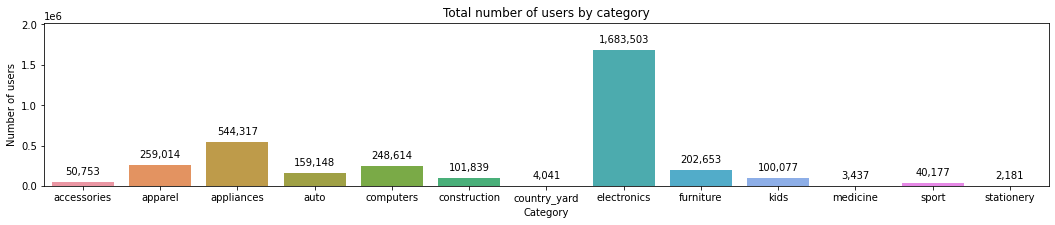

In [ ]:
#creating a plot that illustrates number of visitors in each category during October
plt.figure(figsize=(18,3))
plot = sns.barplot(x='category',y='Number_of_users',data=category_summary_table)
for p in plot.patches:
  plot.annotate(format(p.get_height(), ',.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.title('Total number of users by category')
plt.xlabel('Category')
plt.ylabel('Number of users')
plt.ylim(0,category_summary_table['Number_of_users'].max()*1.2);

In [ ]:
#creating a subcategory summary table
category_subcategory_summary_table=dataset.groupby(by=['category','subcategory']).agg(Number_of_views=('category','count'),
                                                              Number_of_users=('user_id',lambda x: x.nunique()),
                                                              Number_of_sessions=('user_session',pd.Series.nunique)).reset_index()
                                
sales_filter=dataset['event_type']=='purchase'
category_subcategory_sales_summary_table=dataset.loc[sales_filter].groupby(by=['category','subcategory']).agg(Number_of_purchase=('category','count'),
                                                                                      Amount_of_purchase=('price','sum'),
                                                                                      Average_purchase_amount=('price','mean'),
                                                                                      Number_of_sessions_with_purchase=('user_session',pd.Series.nunique),
                                                                                      Number_of_shoppers=('user_id',lambda x: x.nunique())).reset_index()
category_subcategory_summary_table=pd.merge(left=category_subcategory_summary_table,
                               right=category_subcategory_sales_summary_table,
                               left_on=['category','subcategory'],
                               right_on=['category','subcategory'],
                               how='left')
category_subcategory_summary_table['Conversion_rate']=category_subcategory_summary_table['Number_of_purchase']/category_subcategory_summary_table['Number_of_sessions']
category_subcategory_summary_table['category_subcategory']=category_subcategory_summary_table['category']+'-'+category_subcategory_summary_table['subcategory']

category_subcategory_summary_table_sorted=category_subcategory_summary_table.sort_values(by='Number_of_views', ascending=False)

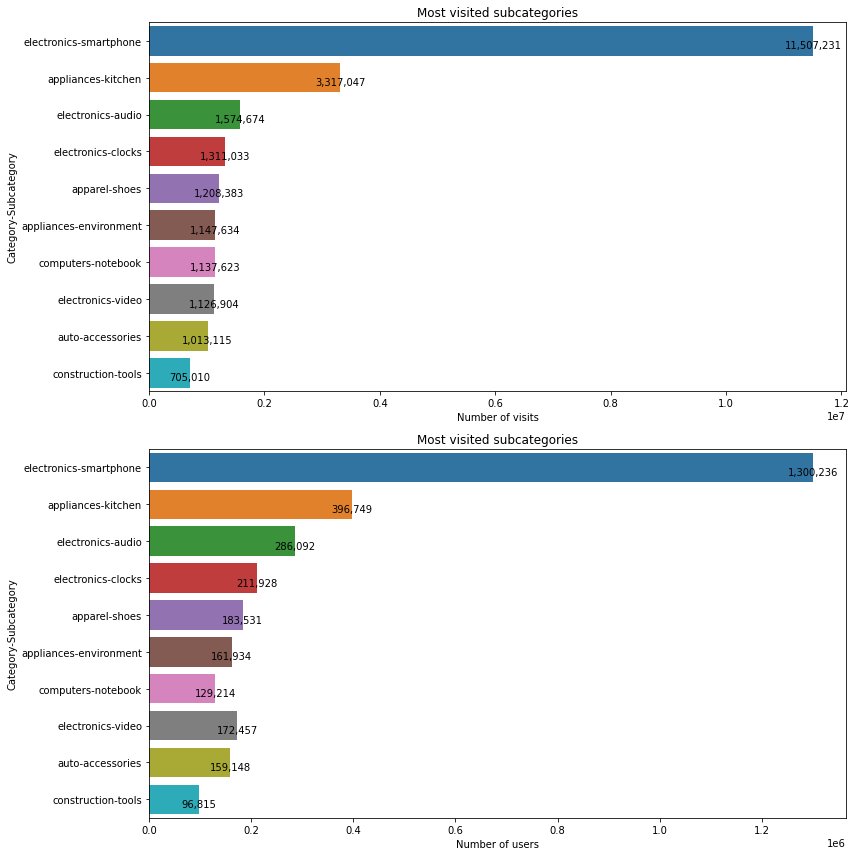

In [ ]:
#creating a plot that shows most popular subcategories and number of visits and visitors during October
fig=plt.figure(figsize=(12,12))
ax1=fig.add_subplot(2,1,1)
plot=sns.barplot(x='Number_of_views',y='category_subcategory_summary_table_sorted',data=category_subcategory_summary_table_sorted.head(10),ax=ax1)
for p in plot.patches:
  plot.annotate(format(p.get_width(), ',.0f'),
                (p.get_x()+p.get_width(), p.get_y() + p.get_height() ),
                ha = 'center',
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
  
plt.title('Most visited subcategories')
plt.xlabel('Number of visits')
plt.ylabel('Category-Subcategory')

ax2=fig.add_subplot(2,1,2)
plot=sns.barplot(x='Number_of_users',y='category_subcategory_summary_table_sorted',data=category_subcategory_summary_table_sorted,ax=ax2)
for p in plot.patches:
  plot.annotate(format(p.get_width(), ',.0f'),
                (p.get_x()+p.get_width(), p.get_y() + p.get_height() ),
                ha = 'center',
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.title('Most visited subcategory')
plt.xlabel('Number of users')
plt.ylabel('Category-Subcategory')
plt.tight_layout()

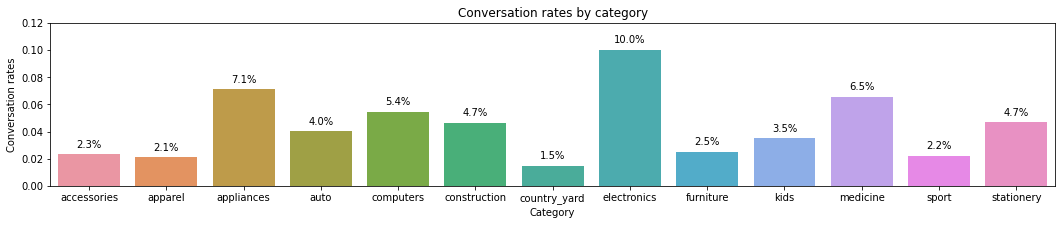

In [ ]:
#creating a plot that represents conversion rates by categories
plt.figure(figsize=(18,3))
plot = sns.barplot(x='category',y='Conversion_rate',data=category_summary_table)
for p in plot.patches:
  plot.annotate("{:.1%}".format(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.title('Conversation rates by category')
plt.xlabel('Category')
plt.ylabel('Conversation rates')
plt.ylim(0,category_summary_table['Conversion_rate'].max()*1.2);

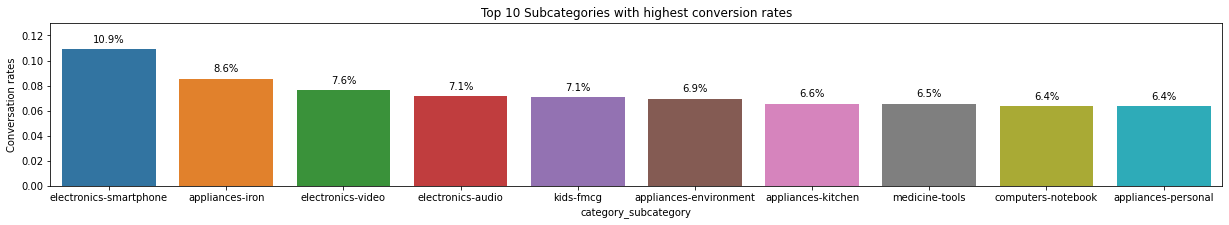

In [ ]:
#creating a plot that represents subcategories with highest conversion rates
plt.figure(figsize=(21,3))
plot = sns.barplot(x='category_subcategory',y='Conversion_rate',data=category_subcategory_summary_table_sorted.head(10))
for p in plot.patches:
  plot.annotate("{:.1%}".format(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.title('Top 10 Subcategories with highest conversion rates')
plt.ylabel('Conversation rates')
plt.ylim(0,category_summary_table['Conversion_rate'].max()*1.3);

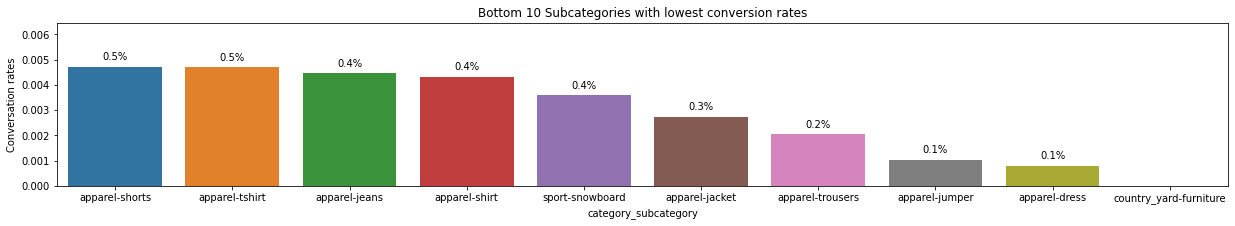

In [ ]:
#creating a plot that represents subcategories with lowest conversion rates
plt.figure(figsize=(21,3))
plot = sns.barplot(x='category_subcategory',y='Conversion_rate',data=category_subcategory_summary_table_sorted.tail(10))
for p in plot.patches:
  plot.annotate("{:.1%}".format(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.title('Bottom 10 Subcategories with lowest conversion rates')
plt.ylabel('Conversation rates')
plt.ylim(0,plot.get_ybound()[1]*1.3);

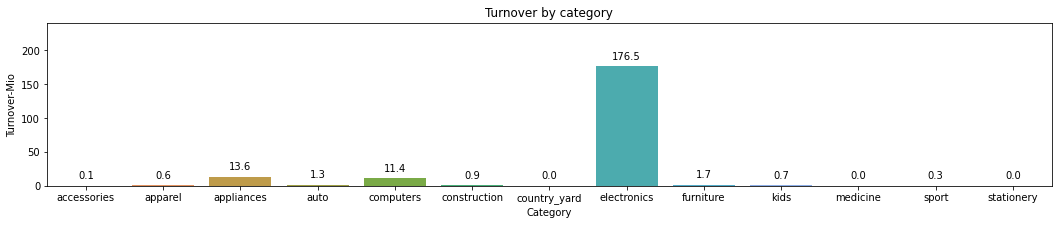

In [ ]:
#creating a category turnover table
category_turnover_table=category_summary_table.groupby(by=['category']).agg(total_turnover=('Amount_of_purchase','sum')).reset_index()
category_turnover_table['total_turn_over_mio']=category_turnover_table['total_turnover']/1000000
#ploting the category turnover table 
plt.figure(figsize=(18,3))
plot = sns.barplot(x='category',y='total_turn_over_mio',data=category_turnover_table)

for p in plot.patches:
  plot.annotate(format(p.get_height(), ',.1f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')


plt.title('Turnover by category')
plt.xlabel('Category')
plt.ylabel('Turnover-Mio')
plt.ylim(0,plot.get_ybound()[1]*1.3);

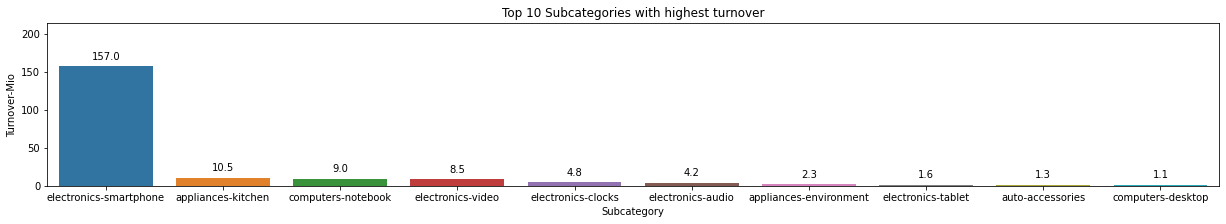

In [ ]:
#creating a subcategory turnover table
subcategory_turnover_table=category_subcategory_summary_table.groupby(by=['category_subcategory']).agg(total_turnover=('Amount_of_purchase','sum')).reset_index()
subcategory_turnover_table=subcategory_turnover_table.sort_values(by=['total_turnover'],ascending=False)
subcategory_turnover_table['total_turn_over_mio']=subcategory_turnover_table['total_turnover']/1000000

#ploting top 10 subcategories with the highest turnover 
plt.figure(figsize=(21,3))
plot = sns.barplot(x='category_subcategory',y='total_turn_over_mio',data=subcategory_turnover_table.head(10))

for p in plot.patches:
  plot.annotate(format(p.get_height(), ',.1f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')


plt.title('Top 10 Subcategories with highest turnover')
plt.xlabel('Subcategory')
plt.ylabel('Turnover-Mio')
plt.ylim(0,plot.get_ybound()[1]*1.3);

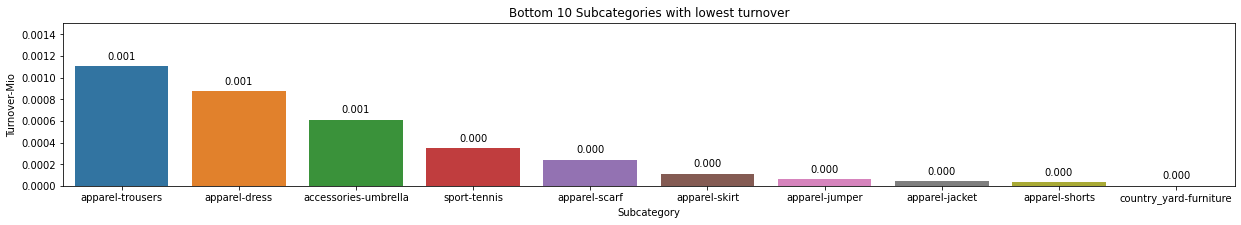

In [ ]:
#ploting top 10 subcategories with the lowest turnover 
plt.figure(figsize=(21,3))
plot = sns.barplot(x='category_subcategory',y='total_turn_over_mio',data=subcategory_turnover_table.tail(10))

for p in plot.patches:
  plot.annotate(format(p.get_height(), ',.3f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')


plt.title('Bottom 10 Subcategories with lowest turnover')
plt.xlabel('Subcategory')
plt.ylabel('Turnover-Mio')
plt.ylim(0,plot.get_ybound()[1]*1.3);